In [1]:
from pprint import pprint
import datetime
import pickle
import threading
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

print(tf.__version__)

2.1.0-dev20191203


In [2]:
def one_hot_df(df,one_hot_cols,drop_cols):
    dfret = df.copy()
    dfret = pd.get_dummies(dfret,columns=one_hot_cols).drop(columns=drop_cols)
    return dfret

In [3]:
def get_data(data_category="base", data_suffix="", one_hot_main=False, one_hot_both=False):
    train_x = pd.read_csv("data/preprocess-%s-x-train%s.csv" % (data_category, data_suffix), index_col=0)
    train_y = pd.read_csv("data/preprocess-%s-y-train%s.csv" % (data_category, data_suffix))
    valid_x = pd.read_csv("data/preprocess-%s-x-valid%s.csv" % (data_category, data_suffix), index_col=0)
    valid_y = pd.read_csv("data/preprocess-%s-y-valid%s.csv" % (data_category, data_suffix))
    
    if data_category == "basic_name" and data_suffix == "-correct":
        train_x.rename(inplace=True, columns={
            "launched_month_deadline_month_0": "launched_month",
            "launched_month_deadline_month_1": "deadline_month"})
        valid_x.rename(inplace=True, columns={
            "launched_month_deadline_month_0": "launched_month",
            "launched_month_deadline_month_1": "deadline_month"})
        for col in train_x.columns:
            if "Unnamed" in col:
                train_x = train_x.drop(col, axis=1)
                valid_x = valid_x.drop(col, axis=1)
        train_y["success"] = train_y["1"]
        valid_y["success"] = valid_y["1"]
    train_y.success = train_y.success.apply(lambda x: 1 if x else 0)
    valid_y.success = valid_y.success.apply(lambda x: 1 if x else 0)
    
    if one_hot_both:
        one_hot_cols = ['main_category', 'category', 'launched_month','deadline_month']
        drop_cols = []
        train_x = one_hot_df(train_x, one_hot_cols, drop_cols)
        valid_x = one_hot_df(valid_x, one_hot_cols, drop_cols)
    elif one_hot_main:
        one_hot_cols = ['main_category','launched_month','deadline_month']
        drop_cols = ['category']
        train_x = one_hot_df(train_x, one_hot_cols, drop_cols)
        valid_x = one_hot_df(valid_x, one_hot_cols, drop_cols)
    
    train_x = np.array(train_x)
    train_y = np.array(train_y.success).reshape((-1, 1))
    valid_x = np.array(valid_x)
    valid_y = np.array(valid_y.success).reshape((-1, 1))
    
    return train_x, train_y, valid_x, valid_y

In [4]:
data_base_one_hot_main = get_data(data_category="base", one_hot_main=True)
data_base_one_hot_both = get_data(data_category="base", one_hot_both=True)
data_base_no_one_hot = get_data(data_category="base", one_hot_main=False)

data_doc2vec_one_hot_main = get_data(data_category="doc2vec", one_hot_main=True)
data_doc2vec_one_hot_both = get_data(data_category="doc2vec", one_hot_both=True)
data_doc2vec_no_one_hot = get_data(data_category="doc2vec", one_hot_main=False)

In [5]:
data_basicname_one_hot_main = get_data(data_category="basic_name", data_suffix="-correct", one_hot_main=True)
data_basicname_one_hot_both = get_data(data_category="basic_name", data_suffix="-correct", one_hot_both=True)
data_basicname_no_one_hot = get_data(data_category="basic_name", data_suffix="-correct", one_hot_main=False)

In [6]:
def build_and_evaluate_model(
    train_x, train_y, valid_x, valid_y,
    epochs=5,
    lr=0.01,
    layer_sizes=(10,),
    dropout=None,
    verbose=True,
    evaluate_every_n_epochs=2):
    print("epochs:", epochs, end=" ")
    print("layer_sizes:", layer_sizes, end=" ")
    print("dropout:", dropout)
    model = Sequential()
    for layer_size in layer_sizes:
        model.add(Dense(layer_size, activation="relu"))
        if dropout is not None:
            model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
#     sgd = SGD(lr=lr, decay=1e-6)
    model.compile(loss="binary_crossentropy",
                 optimizer=sgd,
                 metrics=["accuracy"])
    
    names = model.metrics_names
    if evaluate_every_n_epochs is None:
        model.fit(train_x, train_y, epochs=epochs, batch_size=128, verbose=verbose)
        score = model.evaluate(valid_x, valid_y, batch_size=128, verbose=False)
        names = model.metrics_names
        return {names[i]: score[i] for i in range(len(names))}
    else:
        i = 1
        epoch_evaluations = {}
        while i < epochs + 1:
            print("epoch %s/%s" % (i, epochs))
            model.fit(train_x, train_y, epochs=1, batch_size=128, verbose=verbose)
            if i % evaluate_every_n_epochs == 0:
                epoch_score = model.evaluate(valid_x, valid_y, batch_size=128, verbose=False)
                names = model.metrics_names
                epoch_evaluations[i] = {names[i]: epoch_score[i] for i in range(len(names))}
            i += 1
            
        score = model.evaluate(valid_x, valid_y, batch_size=128, verbose=False)
        names = model.metrics_names
        if i not in epoch_evaluations:
            epoch_evaluations[i] = {names[i]: epoch_score[i] for i in range(len(names))}
        final_results = {names[i]: score[i] for i in range(len(names))}
        final_results["epoch_evaluations"] = epoch_evaluations
        return final_results

In [7]:
def get_appropriate_dataset(one_hot, dataset):
    if one_hot == False:
        if dataset == "base":
            return data_base_no_one_hot
        elif dataset == "doc2vec":
            return data_doc2vec_no_one_hot
        elif dataset == "basicname":
            return data_basicname_no_one_hot
    elif one_hot == "main":
        if dataset == "base":
            return data_base_one_hot_main
        elif dataset == "doc2vec":
            return data_doc2vec_one_hot_main
        elif dataset == "basicname":
            return data_basicname_one_hot_main
    elif one_hot == "both":
        if dataset == "base":
            return data_base_one_hot_both
        elif dataset == "doc2vec":
            return data_doc2vec_one_hot_both
        elif dataset == "basicname":
            return data_basicname_one_hot_both

In [15]:
def build_config(one_hot=False, dataset="base", epochs=5, layer_sizes=(5,), dropout=None, lr=0.01):
    return {
        "one_hot": one_hot,
        "dataset": dataset,
        "epochs": epochs,
        "layer_sizes": layer_sizes,
        "dropout": dropout,
        "lr": lr
    }

def map_wrapper(config):
    data = get_appropriate_dataset(config["one_hot"], config["dataset"])
    return build_and_evaluate_model(
        *data,
        epochs=config["epochs"],
        layer_sizes=config["layer_sizes"],
        dropout=config["dropout"], verbose=False)
    
def get_results_for_configs(configs, concurrent=2):
    config_results = []
#     tp = ThreadPoolExecutor(max_workers=concurrent)
    tp = ProcessPoolExecutor(max_workers=concurrent)
    results = tp.map(map_wrapper, configs)
#     config_results = []
#     for config in configs:
#         print("using config:", config)
#         data = get_appropriate_dataset(config["one_hot"], config["dataset"])

#         t = threading.thread(target=build_and_evaluate_model, args=(
#             *data,
#             epochs=config["epochs"],
#             layer_sizes=config["layer_sizes"],
#             dropout=config["dropout"]))
#         print("results:", results)

#         config_results.append((config, results))
#     return config_results
    return list(zip(configs, results))

In [9]:
# sanity check base vs basicname
base_vs_basicname_configs = [
    build_config(
        one_hot="main",
        dataset="base", epochs=3),
    build_config(
        one_hot="main",
        dataset="basicname", epochs=3)
]

pprint(get_results_for_configs(base_vs_basicname_configs, concurrent=2))

epochs: 3 layer_sizes: (5,) dropout: None
epochs: 3 layer_sizes: (5,) dropout: None
epoch 1/3
epoch 1/3
epoch 2/3
epoch 2/3
epoch 3/3
epoch 3/3
[({'dataset': 'base',
   'dropout': None,
   'epochs': 3,
   'layer_sizes': (5,),
   'lr': 0.01,
   'one_hot': 'main'},
  {'accuracy': 0.63412434,
   'epoch_evaluations': {2: {'accuracy': 0.6337935, 'loss': 0.6375823888912349},
                         4: {'accuracy': 0.6337935,
                             'loss': 0.6375823888912349}},
   'loss': 0.635840537134029}),
 ({'dataset': 'basicname',
   'dropout': None,
   'epochs': 3,
   'layer_sizes': (5,),
   'lr': 0.01,
   'one_hot': 'main'},
  {'accuracy': 0.60080004,
   'epoch_evaluations': {2: {'accuracy': 0.60080004,
                             'loss': 0.6729765116456735},
                         4: {'accuracy': 0.60080004,
                             'loss': 0.6729765116456735}},
   'loss': 0.6715322125495482})]


In [10]:
# demonstrate that one-hot is good
one_hot_configs = [
    build_config(
        one_hot=False,
        dataset="base",
        epochs=3),
    build_config(
        one_hot="main",
        dataset="base",
        epochs=3),
    build_config(
        one_hot="both",
        dataset="base",
        epochs=3),
]

one_hot_demonstration = get_results_for_configs(one_hot_configs, concurrent=4)
pprint(one_hot_demonstration)

epochs: 3 layer_sizes: (5,) dropout: None
epochs: 3 layer_sizes: (5,) dropout: None
epochs: 3 layer_sizes: (5,) dropout: None
epoch 1/3
epoch 1/3
epoch 1/3
epoch 2/3
epoch 2/3
epoch 2/3
epoch 3/3
epoch 3/3
epoch 3/3
[({'dataset': 'base',
   'dropout': None,
   'epochs': 3,
   'layer_sizes': (5,),
   'lr': 0.01,
   'one_hot': False},
  {'accuracy': 0.6008602,
   'epoch_evaluations': {2: {'accuracy': 0.60080004,
                             'loss': 0.6699071919947819},
                         4: {'accuracy': 0.60080004,
                             'loss': 0.6699071919947819}},
   'loss': 0.6695663291904822}),
 ({'dataset': 'base',
   'dropout': None,
   'epochs': 3,
   'layer_sizes': (5,),
   'lr': 0.01,
   'one_hot': 'main'},
  {'accuracy': 0.633192,
   'epoch_evaluations': {2: {'accuracy': 0.63445514,
                             'loss': 0.6374308853806393},
                         4: {'accuracy': 0.63445514,
                             'loss': 0.6374308853806393}},
   'loss': 0.63

<BarContainer object of 3 artists>

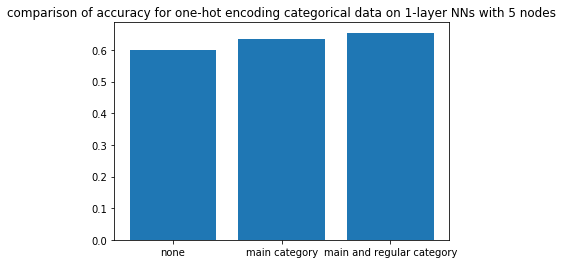

In [11]:
fig, ax = plt.subplots()
ax.set_title("comparison of accuracy for one-hot encoding categorical data on 1-layer NNs with 5 nodes")
ax.bar(["none", "main category", "main and regular category"],
       list(map(lambda x: x[1]["accuracy"], one_hot_demonstration)))

In [12]:
del data_base_no_one_hot
del data_basicname_no_one_hot
del data_doc2vec_no_one_hot
del data_base_one_hot_main
del data_basicname_one_hot_main
del data_doc2vec_one_hot_main

In [16]:
%%time

various_configs = []
# { layer_sizes: , dropout: , one_hot: , dataset: , epochs: }
for node_count in [5, 10, 13]:
    for layer_count in [1, 2, 3]:
        layer_config = tuple([node_count]*layer_count)
        for dropout in [None, 0.3]:
            for dataset in ["base", "doc2vec", "basicname"]:
                various_configs.append(build_config(
                    layer_sizes=layer_config,
                    dropout=dropout,
                    one_hot="both",
                    dataset=dataset,
                    epochs=20))

print("CONFIGURATIONS:")
pprint(various_configs)
print()
print()
config_results = get_results_for_configs(various_configs, concurrent=1)

CONFIGURATIONS:
[{'dataset': 'base',
  'dropout': None,
  'epochs': 20,
  'layer_sizes': (5,),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'doc2vec',
  'dropout': None,
  'epochs': 20,
  'layer_sizes': (5,),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'basicname',
  'dropout': None,
  'epochs': 20,
  'layer_sizes': (5,),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'base',
  'dropout': 0.3,
  'epochs': 20,
  'layer_sizes': (5,),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'doc2vec',
  'dropout': 0.3,
  'epochs': 20,
  'layer_sizes': (5,),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'basicname',
  'dropout': 0.3,
  'epochs': 20,
  'layer_sizes': (5,),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'base',
  'dropout': None,
  'epochs': 20,
  'layer_sizes': (5, 5),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'doc2vec',
  'dropout': None,
  'epochs': 20,
  'layer_sizes': (5, 5),
  'lr': 0.01,
  'one_hot': 'both'},
 {'dataset': 'basicname',
  'dropout': None,

epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (5, 5) dropout: None
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (5, 5) dropout: None
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (5, 5) dropout: 0.3
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
ep

epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (13,) dropout: None
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (13,) dropout: None
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (13,) dropout: None
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20
epochs: 20 layer_sizes: (13,) dropout: 0.3
epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoc

In [17]:
pprint(config_results)

[({'dataset': 'base',
   'dropout': None,
   'epochs': 20,
   'layer_sizes': (5,),
   'lr': 0.01,
   'one_hot': 'both'},
  {'accuracy': 0.6622154,
   'epoch_evaluations': {2: {'accuracy': 0.6546663, 'loss': 0.6161078560326869},
                         4: {'accuracy': 0.65614, 'loss': 0.6113992599803647},
                         6: {'accuracy': 0.6591476, 'loss': 0.6085016920052492},
                         8: {'accuracy': 0.6612831, 'loss': 0.6076041159226399},
                         10: {'accuracy': 0.6617041,
                              'loss': 0.6059218157613764},
                         12: {'accuracy': 0.66429067,
                              'loss': 0.6056577936126335},
                         14: {'accuracy': 0.6643508,
                              'loss': 0.6035999506644735},
                         16: {'accuracy': 0.6665163,
                              'loss': 0.6030459581233458},
                         18: {'accuracy': 0.6654335, 'loss': 0.60255733455492},
  

 ({'dataset': 'doc2vec',
   'dropout': 0.3,
   'epochs': 20,
   'layer_sizes': (10, 10, 10),
   'lr': 0.01,
   'one_hot': 'both'},
  {'accuracy': 0.6570423,
   'epoch_evaluations': {2: {'accuracy': 0.6522903, 'loss': 0.6246858413009565},
                         4: {'accuracy': 0.65472645,
                             'loss': 0.6184842994458414},
                         6: {'accuracy': 0.65388435,
                             'loss': 0.6169247832931882},
                         8: {'accuracy': 0.6563205, 'loss': 0.6151018029654122},
                         10: {'accuracy': 0.64955336,
                              'loss': 0.6164420358958776},
                         12: {'accuracy': 0.6515986,
                              'loss': 0.6159294131336444},
                         14: {'accuracy': 0.6540648,
                              'loss': 0.6146891294140512},
                         16: {'accuracy': 0.6568318,
                              'loss': 0.6122302140428477},
          

In [18]:
file = open("config_results-%s.pickle" % (datetime.datetime.now().timestamp()), "wb")
pickle.dump(config_results, file)
file.close()